In [ ]:
!pip install mediapipe tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled

In [ ]:
import cv2
import os
import glob
import csv
import time
import numpy as np
from PIL import Image
from tqdm import tqdm

import mediapipe as mp

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mp_face = mp.solutions.face_detection

def crop_face_mediapipe(frame_bgr):
    # Convert BGR → RGB for Mediapipe
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.4) as detector:
        results = detector.process(frame_rgb)

        if not results.detections:
            return None

        detection = results.detections[0]
        bbox = detection.location_data.relative_bounding_box

        h, w, _ = frame_rgb.shape

        x1 = int(bbox.xmin * w)
        y1 = int(bbox.ymin * h)
        x2 = int((bbox.xmin + bbox.width) * w)
        y2 = int((bbox.ymin + bbox.height) * h)

        # Clamp coordinates
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(w, x2)
        y2 = min(h, y2)

        face = frame_rgb[y1:y2, x1:x2]

        # Reject tiny/garbage boxes
        if face.shape[0] < 40 or face.shape[1] < 40:
            return None

        return face  # RGB cropped face

In [ ]:
def process_video(video_path, output_frames_dir, fps_sample_rate=1):

    os.makedirs(output_frames_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise Exception(f"❌ Could not open video: {video_path}")

    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(int(video_fps / fps_sample_rate), 1)

    print(f"\n▶ Processing: {video_path}")
    print(f"   FPS: {video_fps:.2f}, Total Frames: {total_frames}, Interval: {frame_interval}")

    frame_idx = 0
    saved_idx = 0
    skipped_faces = 0
    start_time = time.time()

    pbar = tqdm(total=total_frames, desc="Extracting Faces", unit="frame")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % frame_interval == 0:
            face_np = crop_face_mediapipe(frame)

            if face_np is None:
                skipped_faces += 1
            else:
                face_pil = Image.fromarray(face_np)
                filename = f"face_{saved_idx:03d}.jpg"
                save_path = os.path.join(output_frames_dir, filename)
                face_pil.save(save_path)
                saved_idx += 1

        frame_idx += 1
        pbar.update(1)

    cap.release()
    pbar.close()

    total_time = time.time() - start_time
    print(f"\n✔ Done — {saved_idx} faces saved to: {output_frames_dir}")
    print(f"✖ {skipped_faces} frames skipped (no/tiny face)")
    print(f"⏱ Total Time: {total_time:.2f} sec")
    print(f"⏳ Avg Time per Saved Face: {total_time / max(saved_idx,1):.2f} sec\n")

In [ ]:
base_path = "/content/drive/MyDrive/VideoCalls"

for i in range(1, 4):
    folder = f"video_{i:02d}"
    input_folder = f"{base_path}/{folder}/input"

    video_files = glob.glob(f"{input_folder}/*")
    if len(video_files) == 0:
        raise Exception(f"❌ No video found inside: {input_folder}")

    video_path = video_files[0]
    frames_dir = f"{base_path}/{folder}/frames"

    os.makedirs(frames_dir, exist_ok=True)

    process_video(video_path, frames_dir, fps_sample_rate=1)  # 1 frame/sec


▶ Processing: /content/drive/MyDrive/VideoCalls/video_01/input/Video.mp4
   FPS: 25.00, Total Frames: 14371, Interval: 25


Extracting Faces: 100%|██████████| 14371/14371 [01:06<00:00, 214.74frame/s]



✔ Done — 573 faces saved to: /content/drive/MyDrive/VideoCalls/video_01/frames
✖ 2 frames skipped (no/tiny face)
⏱ Total Time: 66.93 sec
⏳ Avg Time per Saved Face: 0.12 sec


▶ Processing: /content/drive/MyDrive/VideoCalls/video_02/input/Video.mp4
   FPS: 25.00, Total Frames: 30300, Interval: 25


Extracting Faces: 100%|██████████| 30300/30300 [02:36<00:00, 193.04frame/s]



✔ Done — 1209 faces saved to: /content/drive/MyDrive/VideoCalls/video_02/frames
✖ 3 frames skipped (no/tiny face)
⏱ Total Time: 156.97 sec
⏳ Avg Time per Saved Face: 0.13 sec


▶ Processing: /content/drive/MyDrive/VideoCalls/video_03/input/Video.mp4
   FPS: 25.00, Total Frames: 32288, Interval: 25


Extracting Faces: 100%|██████████| 32288/32288 [02:52<00:00, 187.07frame/s]


✔ Done — 1225 faces saved to: /content/drive/MyDrive/VideoCalls/video_03/frames
✖ 67 frames skipped (no/tiny face)
⏱ Total Time: 172.60 sec
⏳ Avg Time per Saved Face: 0.14 sec



In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import os
import csv
from PIL import Image

# Emotion mapping
EMOTIONS = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# Global variables
images_list = []
current_index = 0
csv_writer = None
csv_file = None
total_images = 0

def load_images(frames_folder, output_csv):
    global images_list, current_index, csv_writer, csv_file, total_images

    images_list = sorted([os.path.join(frames_folder, f)
                          for f in os.listdir(frames_folder) if f.endswith('.jpg')])

    total_images = len(images_list)
    current_index = 0

    if total_images == 0:
        return None, "❌ No images found!", 0, 0.0

    # Open CSV
    csv_file = open(output_csv, 'w', newline='')
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["frame_id", "filename", "label"])

    img = Image.open(images_list[current_index])
    return img, f"Loaded {total_images} images. Begin labeling!", 0, 0.0


def update_progress():
    """Returns (count, percent_float)."""
    count = current_index
    percent = (count / total_images) * 100 if total_images > 0 else 0
    return count, percent


def label_image(label):
    global current_index, csv_writer, csv_file

    img_path = images_list[current_index]
    filename = os.path.basename(img_path)

    # Write label
    csv_writer.writerow([current_index, filename, label])
    csv_file.flush()

    current_index += 1

    if current_index >= total_images:
        csv_file.close()
        return None, f"🎉 All images labeled!", total_images, 100.0

    img = Image.open(images_list[current_index])
    count, percent = update_progress()
    return img, f"Labeled {filename} → {label}", count, percent


def skip_image():
    global current_index, csv_writer, csv_file

    filename = os.path.basename(images_list[current_index])

    csv_writer.writerow([current_index, filename, "skip"])
    csv_file.flush()

    current_index += 1

    if current_index >= total_images:
        csv_file.close()
        return None, "🎉 All images labeled!", total_images, 100.0

    img = Image.open(images_list[current_index])
    count, percent = update_progress()
    return img, f"⏭ Skipped {filename}", count, percent


# ------------------- GRADIO UI -------------------
with gr.Blocks() as demo:
    gr.Markdown("## 🎨 Manual Emotion Labeling Tool")

    with gr.Row():
        folder_input = gr.Textbox(label="Frames Folder Path")
        csv_output = gr.Textbox(label="Output CSV Path")

    load_btn = gr.Button("Load Images")

    image_display = gr.Image(label="Image")
    status_display = gr.Textbox(label="Status", interactive=False)

    count_display = gr.Number(label="Labeled Images", interactive=False)
    progress_bar = gr.Slider(label="Progress (%)", minimum=0, maximum=100, interactive=False)

    # Emotion buttons
    with gr.Row():
        for emotion in EMOTIONS:
            gr.Button(emotion).click(
                label_image,
                inputs=gr.Textbox(value=emotion),
                outputs=[image_display, status_display, count_display, progress_bar],
            )

    skip_btn = gr.Button("Skip")
    skip_btn.click(
        skip_image,
        outputs=[image_display, status_display, count_display, progress_bar],
    )

    # Load images
    load_btn.click(
        load_images,
        inputs=[folder_input, csv_output],
        outputs=[image_display, status_display, count_display, progress_bar],
    )

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2f1b2c0cd0b415ef60.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Found 573 images to label.


----------------------------------------
Image 1/573  →  face_000.jpg
Press a number key to label this image:
0 = angry
1 = disgust
2 = fear
3 = happy
4 = sad
5 = surprise
6 = neutral
----------------------------------------


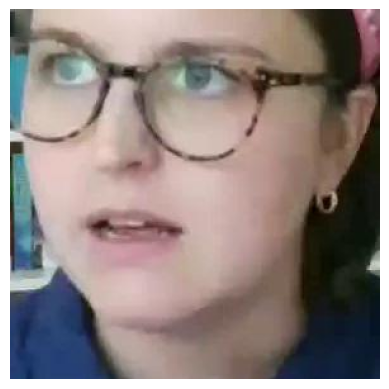

KeyboardInterrupt: Interrupted by user

In [ ]:
frames_folder = "/content/drive/MyDrive/VideoCalls/video_01/frames"
output_csv = "/content/drive/MyDrive/VideoCalls/video_01/manual_labels.csv"

manual_labeling_tool(frames_folder, output_csv)


In [ ]:
!pip install fer opencv-python-headless pandas


INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.1/891.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.2 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import os
import pandas as pd

In [ ]:
weights = ResNet18_Weights.FER_PLUS_V1
model = resnet18(weights=weights)
model.eval()

preprocess = weights.transforms()   # ready-made preprocessing pipeline


AttributeError: type object 'ResNet18_Weights' has no attribute 'FER_PLUS_V1'